# 1 - Introduction

In this notebook we're going to do the exploratory data analysis with the data we have available, we'll raise some pertinent questions and answear with data.
We'll try to see the relation between the revenue price and the quantity sold, and in the next notebook the goal is to create a model to predict the quantity sold based on the revenue price.

We have available the following variables:
- PROD_ID: Product ID. We provide data for 9 different products, P1 to P9;
- DATE_ORDER: Sales Date, under YYYY-MM-DD format;
- QTY_ORDER: Quantity Sold;
- REVENUE: Sale revenue. There can be variations of the price for the same product, depending on the sales channel or discounts, which are applied to the base price;
- DATE_EXTRACTION: Date and Time of the extraction of the competitors’ price, under YYYY-MM-DD HH:MM:SS format;
- COMPETITOR: Competitors’ ID (C1 to C6);
- COMPETITOR_PRICE: Competitors’ price per product, which can depend on the payment method;
- PAY_TYPE: Payment Method (1=deferred payment, 2=immediate payment).

### 1.1 Setting the environment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import numpy as np
import warnings


warnings.filterwarnings('ignore')
register_matplotlib_converters()
sns.set_style("darkgrid")
%matplotlib inline
path = 'data/'

In [2]:
sales = pd.read_csv(path + "sales.csv")
sales['DATE_ORDER'] =  pd.to_datetime(sales['DATE_ORDER'])
sales.head()

PROD_ID DATE_ORDER  QTY_ORDER  REVENUE
0      P6 2015-08-02        1.0  1808.99
1      P6 2015-08-17        1.0  1674.00
2      P6 2015-08-17        1.0  1673.95
3      P6 2015-08-11        1.0  1674.00
4      P6 2015-08-17        1.0  1674.00

In [3]:
comp_prices = pd.read_csv(path + "comp_prices.csv")
comp_prices['DATE_EXTRACTION'] =  pd.to_datetime(comp_prices['DATE_EXTRACTION'])
comp_prices.head()

PROD_ID     DATE_EXTRACTION COMPETITOR  COMPETITOR_PRICE  PAY_TYPE
0      P6 2015-01-30 08:11:38         C3           1898.00         1
1      P6 2015-01-30 08:11:38         C1           1898.00         1
2      P6 2015-01-30 08:11:38         C6           1999.90         1
3      P6 2015-01-31 20:10:14         C2           1894.88         2
4      P6 2015-01-31 20:10:14         C3           1894.88         2

### 1.2 Data cleaning

In [4]:
sales.isnull().sum()

PROD_ID       0
DATE_ORDER    0
QTY_ORDER     0
REVENUE       0
dtype: int64

In [5]:
comp_prices.isnull().sum()

PROD_ID             0
DATE_EXTRACTION     0
COMPETITOR          0
COMPETITOR_PRICE    0
PAY_TYPE            0
dtype: int64

In [6]:
# tipos das variáveis nos sales
sales.dtypes

PROD_ID               object
DATE_ORDER    datetime64[ns]
QTY_ORDER            float64
REVENUE              float64
dtype: object

In [7]:
# tipos das variáveis nos comp_prices
comp_prices.dtypes

PROD_ID                     object
DATE_EXTRACTION     datetime64[ns]
COMPETITOR                  object
COMPETITOR_PRICE           float64
PAY_TYPE                     int64
dtype: object

In [8]:
products = sorted(sales["PROD_ID"].unique())
print("Products: {}".format(products))

Products: ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']


In [9]:
sorted(comp_prices["PROD_ID"].unique())

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']

In [10]:
sales.loc[sales["PROD_ID"] == products[0]]['REVENUE'].describe()

count     4091.000000
mean      1470.079868
std        466.296394
min       1145.780000
25%       1399.000000
50%       1499.000000
75%       1499.000000
max      25887.600000
Name: REVENUE, dtype: float64

In [11]:
comp_prices.loc[comp_prices["PROD_ID"] == products[0]]['COMPETITOR_PRICE'].describe()

count      2713.000000
mean       1907.524689
std        7717.927043
min        1090.000000
25%        1424.050000
50%        1499.000000
75%        1499.000000
max      149900.000000
Name: COMPETITOR_PRICE, dtype: float64

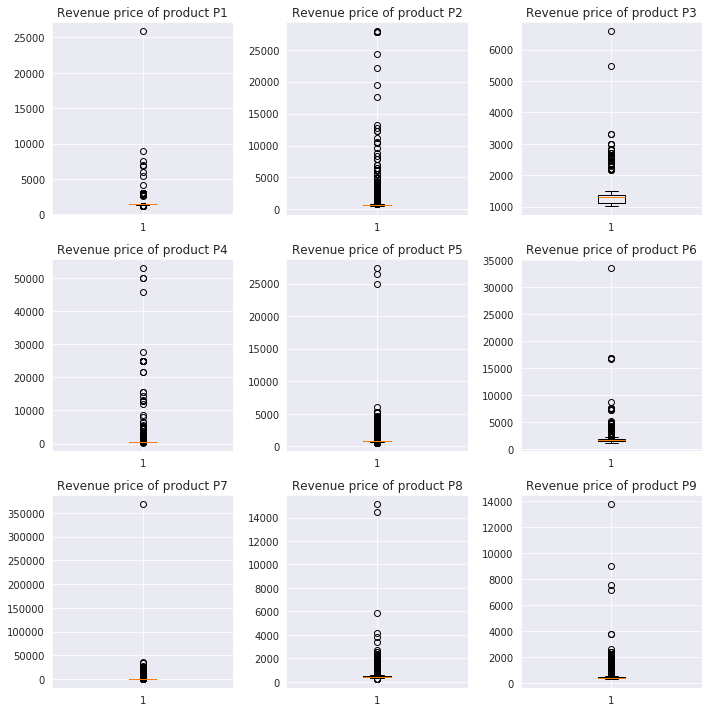

In [12]:
plt.figure(figsize=(10, 10))

for idx, prod in enumerate(products):
    plt.subplot(3, 3, idx+1)
    
    plt.boxplot(sales.loc[sales['PROD_ID'] == prod]['REVENUE'])
    plt.title("Revenue price of product {}".format(prod))


plt.tight_layout()
plt.show()

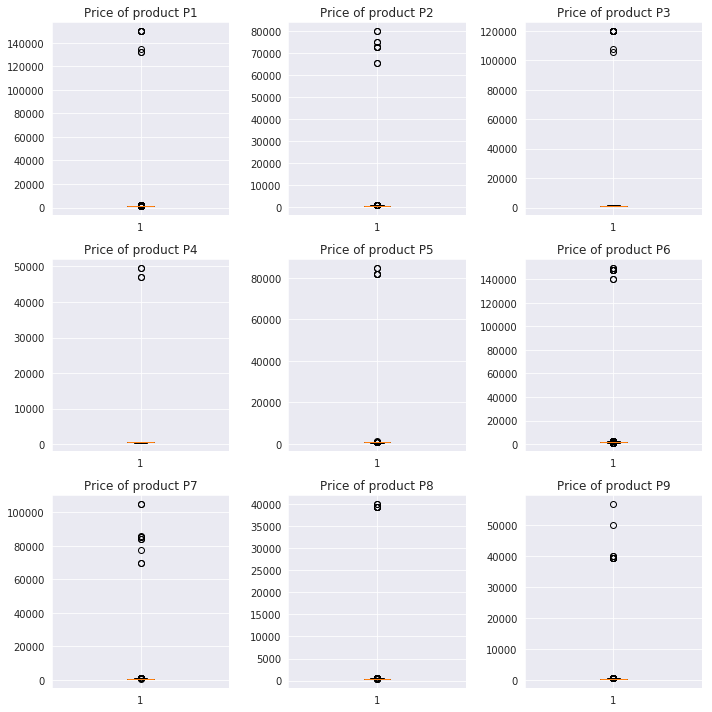

In [13]:
plt.figure(figsize=(10, 10))

for idx, prod in enumerate(products):
    plt.subplot(3, 3, idx+1)
    
    plt.boxplot(comp_prices.loc[comp_prices['PROD_ID'] == prod]['COMPETITOR_PRICE'])
    plt.title("Price of product {}".format(prod))


plt.tight_layout()
plt.show()

In the boxplots showed above, we can see we have outliers (or mistakes) in the data, so we need to decide how to deal with them, we have some options like remove them or change them to the some value (mean, median, mode, max value within the distribution.
In the next step we are going to change them to the median.

## 1.2.1 Median filter

In [14]:
def medians_quartiles(df, col_name):
    quartiles_99 = []
    medians = []

    for prod in products: 
        data = df.loc[df["PROD_ID"] == prod][col_name]
        quartiles_99.append(np.percentile(data,99))
        medians.append(np.median(data))

    return medians, quartiles_99

In [15]:
def median_filter(price, prod, medians, quartiles):
    index = products.index(prod)
    if price > quartiles[index]:
        return medians[index]
    return price

In [16]:
med_comp, quart_comp =  medians_quartiles(sales, "REVENUE")
med_sales, quart_sales = medians_quartiles(comp_prices, "COMPETITOR_PRICE")

In [17]:
sales['REVENUE'] = sales.apply(lambda row: median_filter(row['REVENUE'], row['PROD_ID'], med_sales, quart_sales), axis=1)
comp_prices['COMPETITOR_PRICE'] = comp_prices.apply(lambda row: median_filter(row['COMPETITOR_PRICE'], row['PROD_ID'], med_comp, quart_comp), axis=1)

print(comp_prices.loc[comp_prices["PROD_ID"] == products[0]]['COMPETITOR_PRICE'].describe())
print(sales.loc[sales["PROD_ID"] == products[0]]['REVENUE'].describe())


count    2713.000000
mean     1488.710829
std       159.139939
min      1090.000000
25%      1424.050000
50%      1499.000000
75%      1499.000000
max      1899.000000
Name: COMPETITOR_PRICE, dtype: float64
count    4091.000000
mean     1442.803997
std        66.867720
min      1145.780000
25%      1399.000000
50%      1499.000000
75%      1499.000000
max      1499.000000
Name: REVENUE, dtype: float64


# 2 - Data exploration

## 2.1 - Sales dataframe
In this part we are going to aggregating the data to find how many units were sold per day, which products are the most popular and more.

The first step will be create the variable to retrieve the unit value of the product, and work with the new dataframe with the aggragated information.

In [26]:
df_sales = sales.groupby(by=['PROD_ID', 'DATE_ORDER'])[['QTY_ORDER', 'REVENUE']].sum().reset_index()
df_sales['UNIT_VALUE'] = df_sales['REVENUE']/df_sales['QTY_ORDER']

In [27]:
df_sales.head()

PROD_ID DATE_ORDER  QTY_ORDER  REVENUE  UNIT_VALUE
0      P1 2015-02-04      10.00 14990.00     1499.00
1      P1 2015-02-05      12.00 17688.20     1474.02
2      P1 2015-02-06      21.00 31254.15     1488.29
3      P1 2015-02-07       4.00  5996.00     1499.00
4      P1 2015-02-08       7.00 10493.00     1499.00

In [38]:
print('Quantity sold per product in the period')
df_sales.groupby(by=['PROD_ID'])['QTY_ORDER'].sum().reset_index().sort_values(by='QTY_ORDER', ascending=False)

Quantity sold per product in the period


PROD_ID  QTY_ORDER
6      P7  211722.00
1      P2   67844.00
7      P8   29820.00
4      P5   21055.00
8      P9   19661.00
3      P4   17309.00
5      P6    4237.00
0      P1    4173.00
2      P3    2949.00

In [39]:
print("Total revenue values agg by product in the period")
pd.options.display.float_format = '{:.2f}'.format
df_sales.groupby(by=['PROD_ID'])['REVENUE'].sum().reset_index().sort_values(by='REVENUE', ascending=False)

Total revenue values agg by product in the period


PROD_ID      REVENUE
6      P7 149822375.07
1      P2  43363480.51
4      P5  15068722.34
7      P8  11446004.67
8      P9   7537698.78
3      P4   7197458.02
5      P6   6846246.27
0      P1   5902511.15
2      P3   3654678.39

Total orders per product


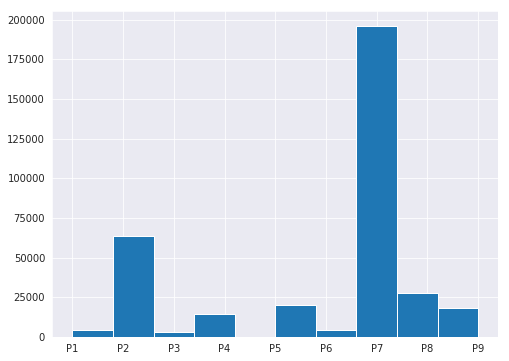

In [44]:
print("Total orders per product")
plt.figure(figsize=(8,6))
plt.hist(sales["PROD_ID"])
plt.show()

#### The best sellers in quantity were:
    - P7, P2 e P8

#### The best sellers in revenue value were:
    - P7, P2 e P5
    
#### The most populars (that appeared in more distinct orders) were the same as the best sellers

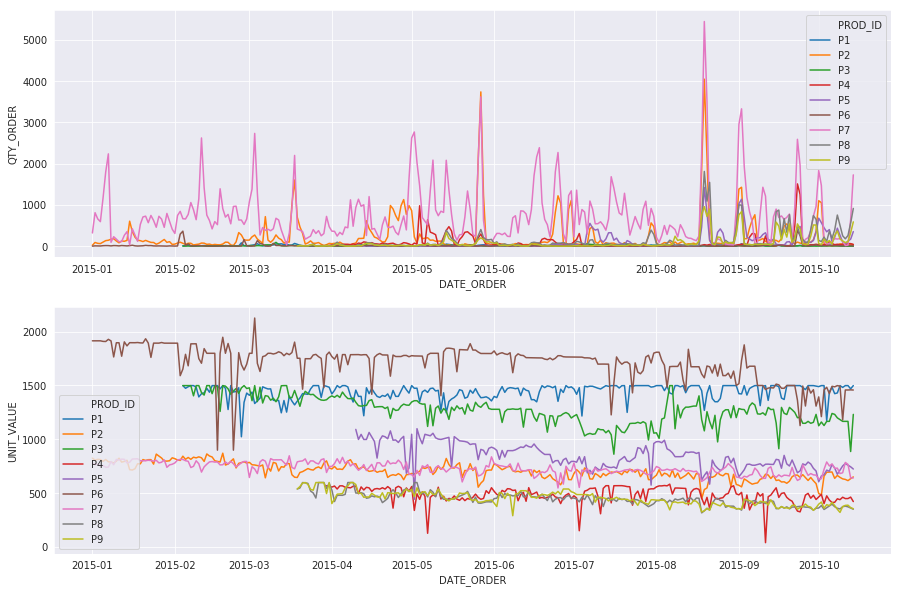

In [45]:
rcParams['figure.figsize'] = 15, 10

plt.subplot(2, 1, 1)
sns.lineplot(x="DATE_ORDER", y="QTY_ORDER", hue ='PROD_ID', data=df_sales)

plt.subplot(2, 1, 2)
sns.lineplot(x="DATE_ORDER", y="UNIT_VALUE", hue ='PROD_ID',data=df_sales)

plt.show()

In [32]:
df_sales.groupby(by=['PROD_ID'])['UNIT_VALUE'].std().reset_index().rename(columns={"UNIT_VALUE": "STD"}).sort_values(by='STD', ascending=False)

PROD_ID    STD
5      P6 166.28
2      P3 129.33
4      P5 118.79
3      P4  75.20
1      P2  73.34
0      P1  69.05
8      P9  65.11
7      P8  61.66
6      P7  54.39

The products that had the biggest standard deviation during the period were P6, P3 and P5.

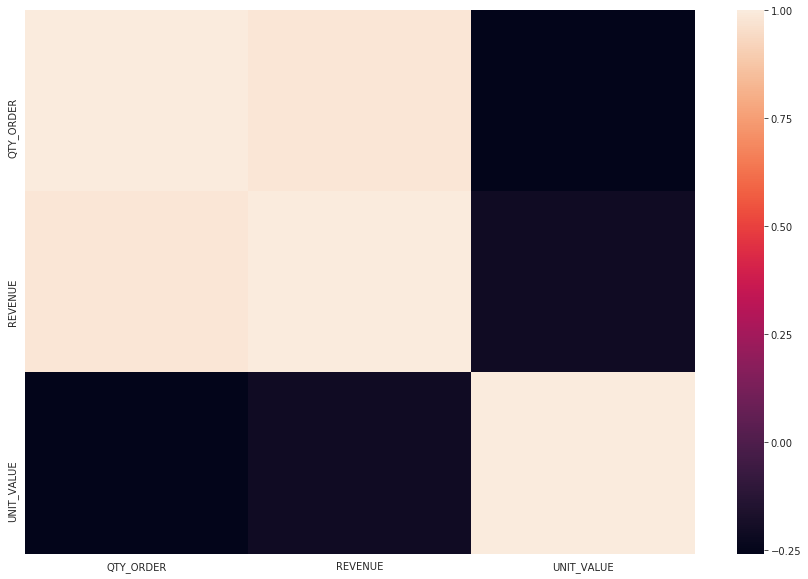

In [34]:
corr = df_sales.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In the next graphs we can see the distibution of the unit values and quantity sold, agg per date in the first one and without the date in the second one.

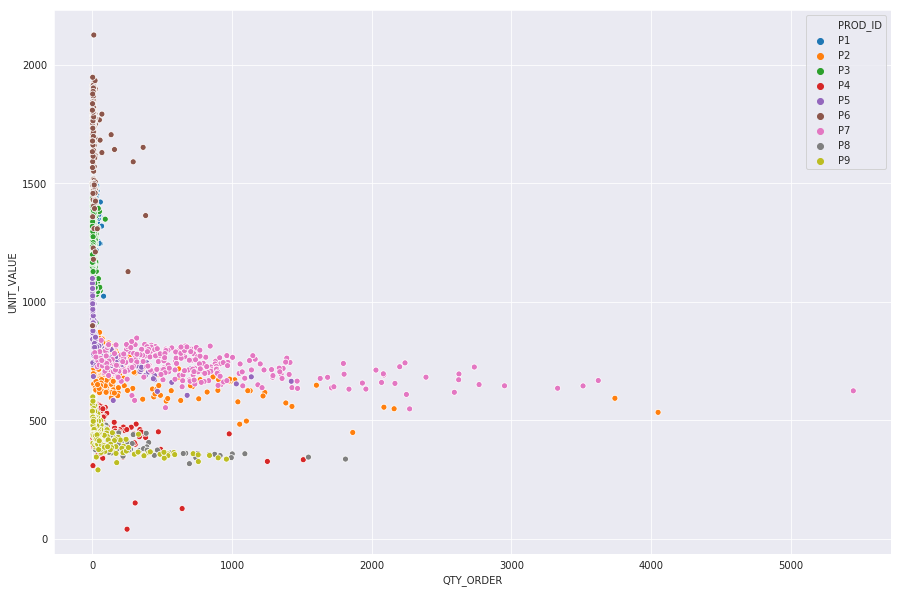

In [36]:
ax = sns.scatterplot(x='QTY_ORDER', y='UNIT_VALUE', hue='PROD_ID', data=df_sales)

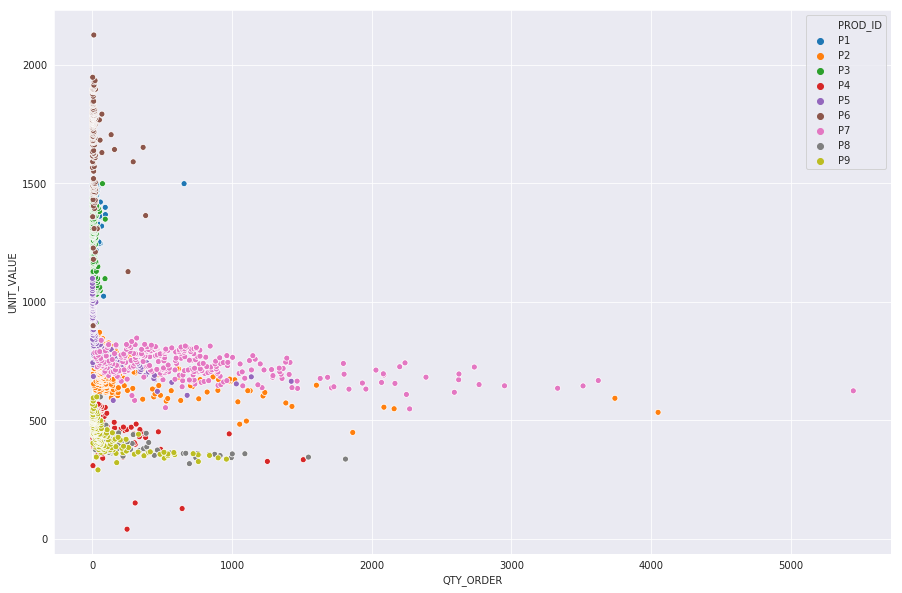

In [47]:
df_sales_aux = df_sales.groupby(by=['PROD_ID','UNIT_VALUE'])['QTY_ORDER'].sum().reset_index()
ax = sns.scatterplot(x='QTY_ORDER', y='UNIT_VALUE', hue='PROD_ID', data=df_sales_aux)

The date doesn't seems to affect the relation of price and quantity.
 
 
Below we can see P1's value along the timeline

In [49]:
df_p1 = df_sales.loc[df_sales['PROD_ID'] == products[0]].copy()
df_p1.sort_values(by='UNIT_VALUE', inplace=True)
df_p1.reset_index(inplace=True, drop=True)

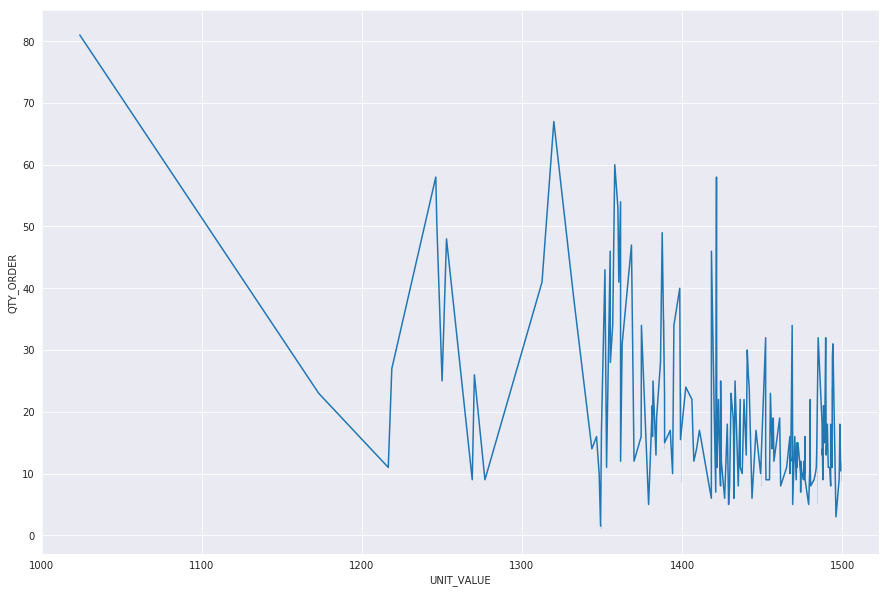

In [50]:
rcParams['figure.figsize'] = 15,10
ax = sns.lineplot(x="UNIT_VALUE", y="QTY_ORDER", data=df_p1)

### In the graph below we want to compare the the evolution the price versus the quantity sold

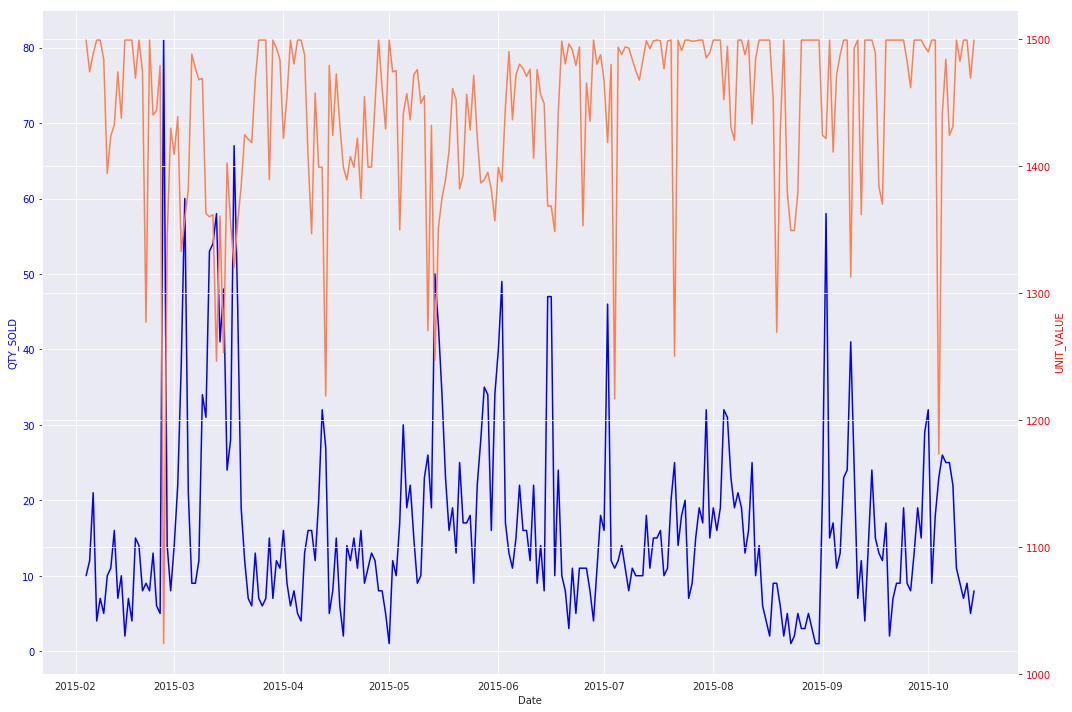

In [51]:
df_p1.sort_values(by='DATE_ORDER', inplace=True)
df_p1.reset_index(inplace=True, drop=True)

rcParams['figure.figsize'] = 15,10
fig, ax1 = plt.subplots()

color = "blue"
ax1.set_xlabel('Date')
ax1.set_ylabel('QTY_SOLD', color=color)
ax1.plot(df_p1["DATE_ORDER"], df_p1["QTY_ORDER"], color = color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = "red"
ax2.set_ylabel("UNIT_VALUE", color=color) 
ax2.plot(df_p1["DATE_ORDER"], df_p1["UNIT_VALUE"], color='coral')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## 2.2 - Competitors dataframe

In [20]:
comp_prices = comp_prices.sort_values(by='DATE_EXTRACTION').reset_index(drop=True)
comp_prices[:10]

PROD_ID     DATE_EXTRACTION COMPETITOR  COMPETITOR_PRICE  PAY_TYPE
0      P7 2015-01-01 08:10:25         C4            799.00         1
1      P6 2015-01-01 08:10:25         C6           2799.90         1
2      P6 2015-01-01 08:10:25         C1           1959.90         1
3      P6 2015-01-01 08:10:25         C3           1914.90         1
4      P6 2015-01-01 08:10:25         C1           1959.90         2
5      P6 2015-01-01 08:10:25         C6           2799.90         2
6      P7 2015-01-01 08:10:25         C4            703.12         2
7      P7 2015-01-01 08:10:25         C5            759.05         2
8      P6 2015-01-01 08:10:25         C3           1914.90         2
9      P7 2015-01-01 08:10:25         C5            799.00         1

## In the graph below we have Deffered payment x immediate payment per competitor 

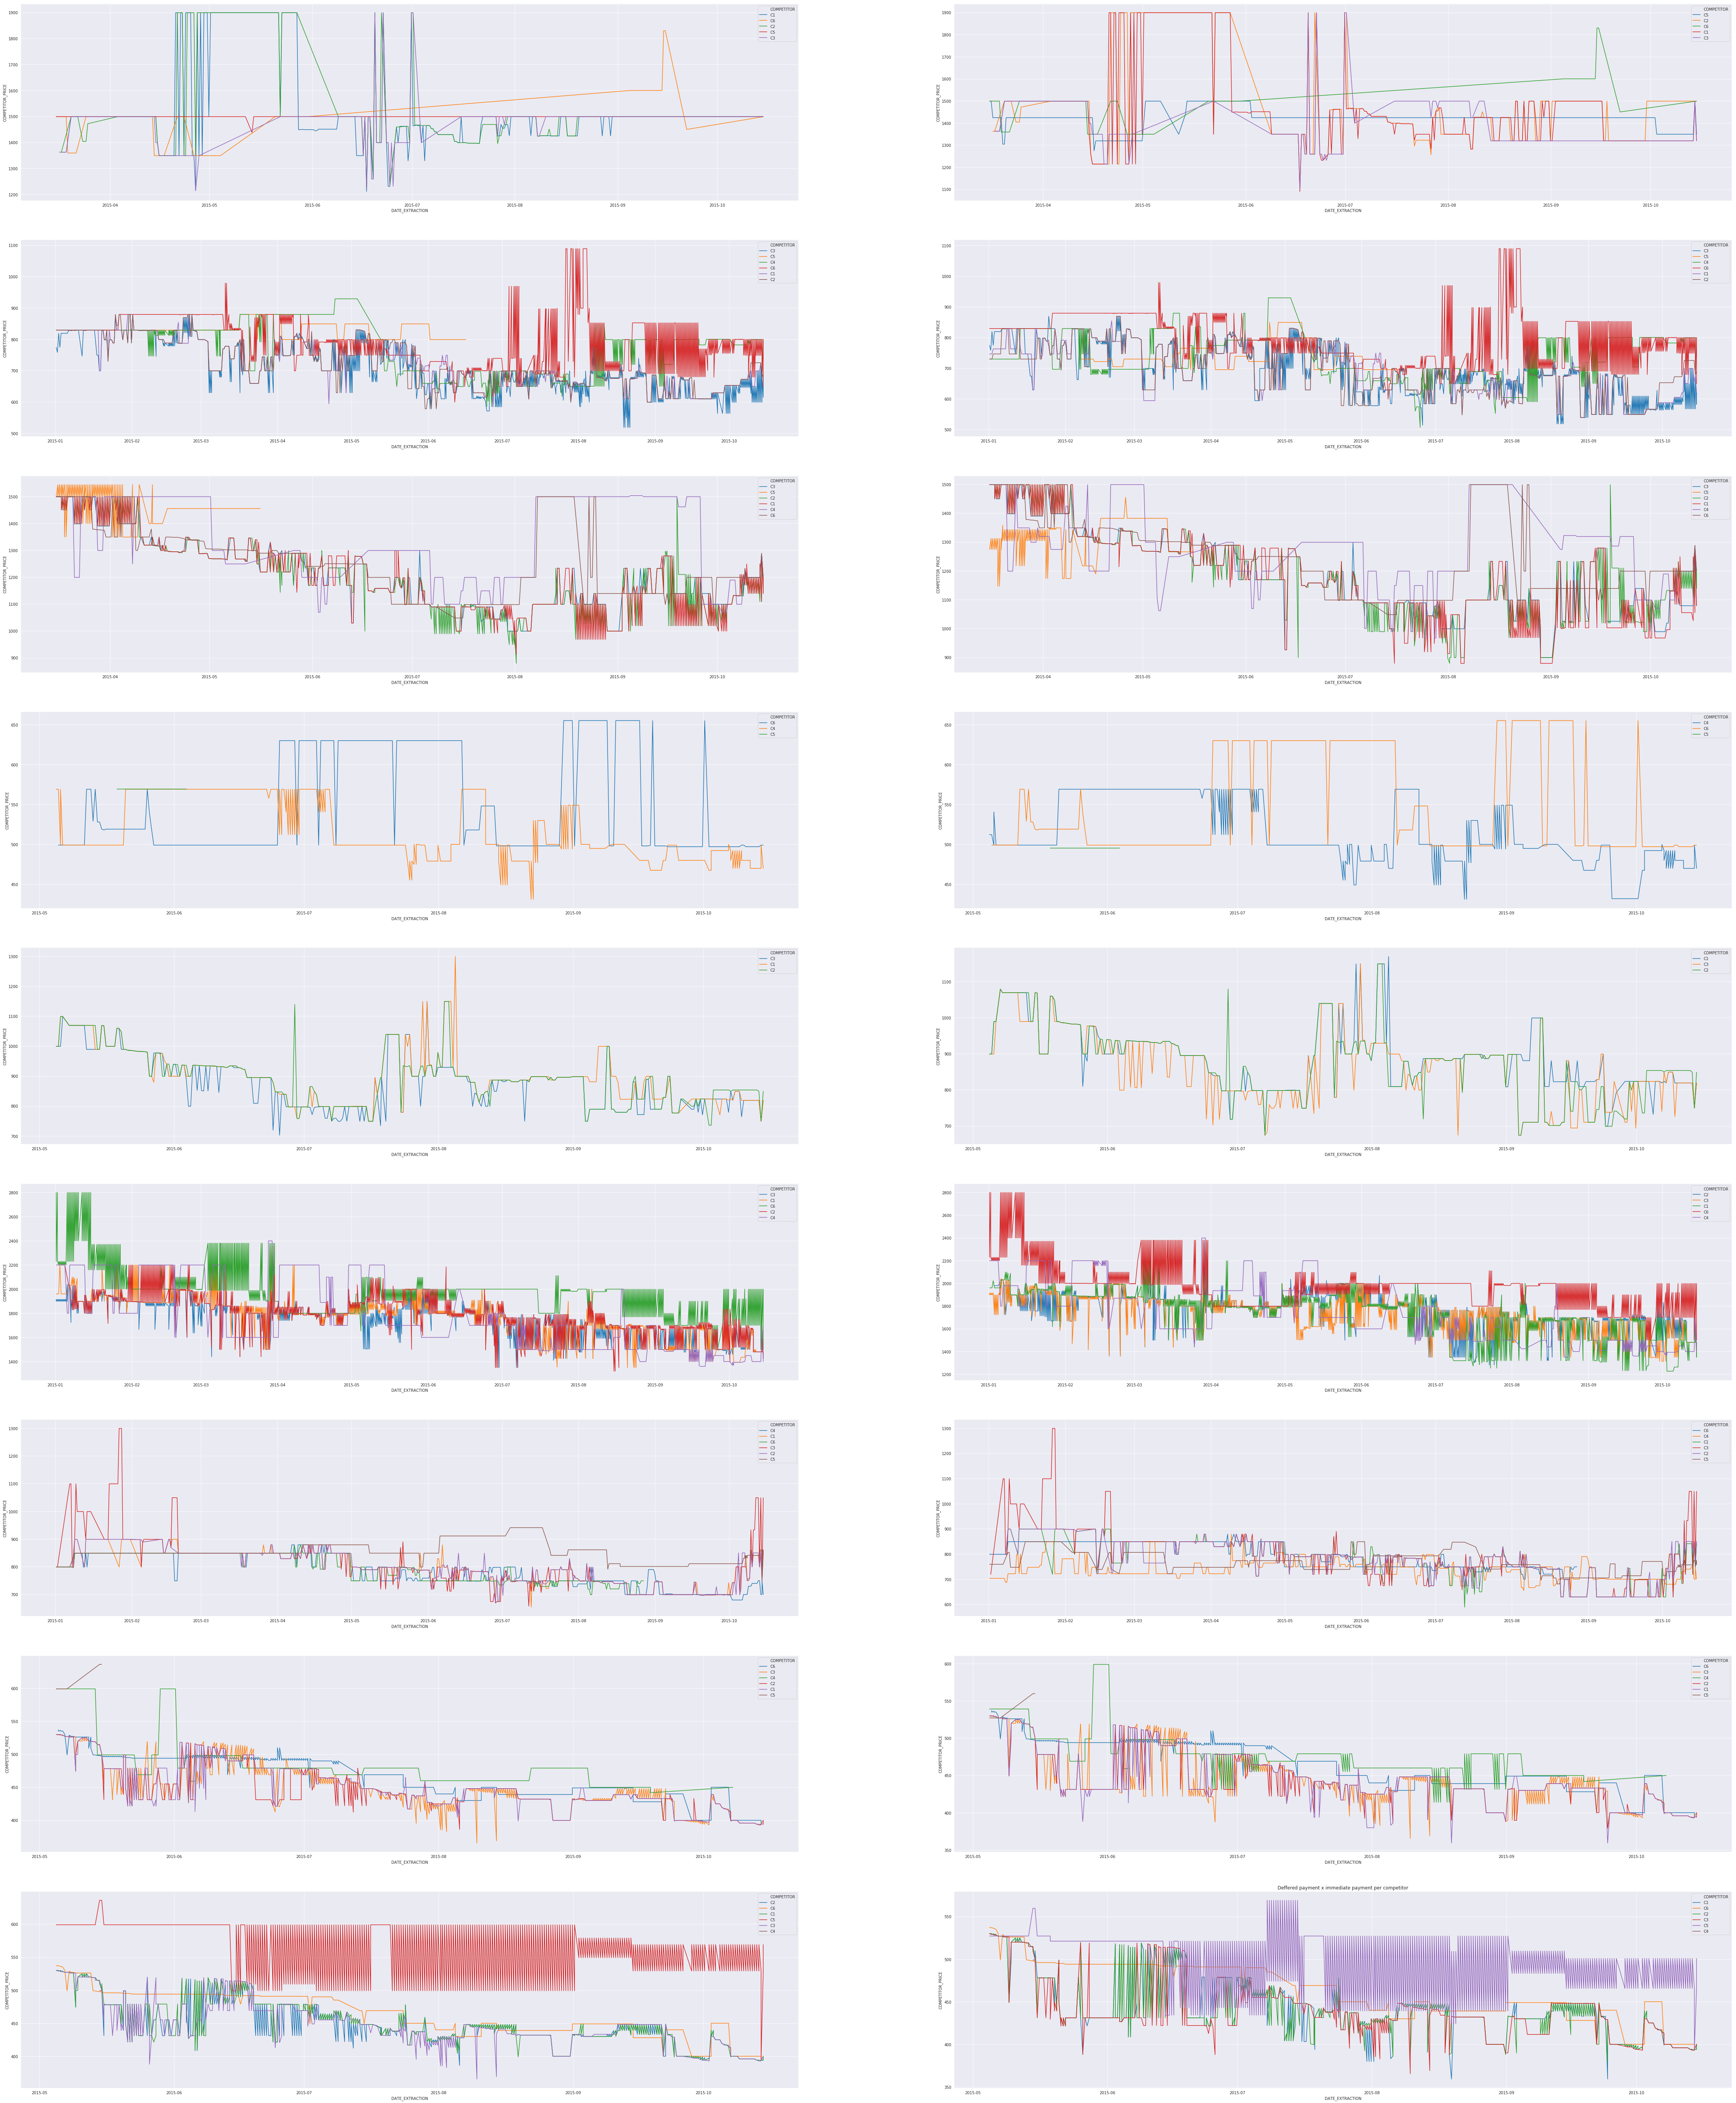

In [61]:
plt.figure(figsize=(80, 100))   

for idx, prod in enumerate(products):
    plt.subplot(9, 2, 2*idx+1)
    df_prod = comp_prices.loc[(comp_prices["PAY_TYPE"] == 1) & (comp_prices["PROD_ID"] == prod)]
    ax = sns.lineplot(x="DATE_EXTRACTION", y="COMPETITOR_PRICE", hue ="COMPETITOR", data=df_prod)
    
    plt.subplot(9, 2, 2*idx+2)
    df_prod = comp_prices.loc[(comp_prices["PAY_TYPE"] == 2) & (comp_prices["PROD_ID"] == prod)]
    ax = sns.lineplot(x="DATE_EXTRACTION", y="COMPETITOR_PRICE", hue ="COMPETITOR", data=df_prod)
    
plt.show()

In [72]:
print("Price variation per competitor")
comp_prices.groupby(by=['COMPETITOR', 'PROD_ID'])['COMPETITOR_PRICE'].std().reset_index().rename(columns={"COMPETITOR_PRICE": "STD"}).sort_values(by='STD', ascending=False)[:10]

Price variation per competitor


COMPETITOR PROD_ID    STD
27         C4      P6 293.96
42         C6      P6 220.43
8          C2      P1 200.26
4          C1      P6 200.23
0          C1      P1 194.98
12         C2      P6 166.54
20         C3      P6 156.72
2          C1      P3 149.57
10         C2      P3 146.57
25         C4      P3 145.31

Between the top 10, the product that suffered the most variation was P6 and the competitors that changed the most the prices was C1 and C4

In [75]:
print("Price means")
prod_means = comp_prices.groupby(by=['PROD_ID'])['COMPETITOR_PRICE'].mean().reset_index().rename(columns={"COMPETITOR_PRICE": "MEAN"}).sort_values(by='MEAN', ascending=False)[:10]
prod_means

Price means


PROD_ID    MEAN
5      P6 1799.57
0      P1 1488.71
2      P3 1223.49
4      P5  882.33
6      P7  784.51
1      P2  737.29
3      P4  529.72
8      P9  465.29
7      P8  455.56

In [87]:
def bigger_price(product, price):
    p_mean = prod_means.loc[prod_means['PROD_ID'] == product]['MEAN'].values[0]
    return price - p_mean

In [88]:
comp_prices['PRICE_DIFF'] = comp_prices.apply(lambda row: bigger_price(row['PROD_ID'], row['COMPETITOR_PRICE']), axis=1)


In [89]:
comp_prices.head()

PROD_ID     DATE_EXTRACTION COMPETITOR  COMPETITOR_PRICE  PAY_TYPE  \
0      P6 2015-01-30 08:11:38         C3           1898.00         1   
1      P6 2015-01-30 08:11:38         C1           1898.00         1   
2      P6 2015-01-30 08:11:38         C6           1999.90         1   
3      P6 2015-01-31 20:10:14         C2           1894.88         2   
4      P6 2015-01-31 20:10:14         C3           1894.88         2   

   PRICE_DIFF  
0       98.43  
1       98.43  
2      200.33  
3       95.31  
4       95.31

In [90]:
exp = comp_prices.loc[comp_prices['PRICE_DIFF'] > 0]
cheap = comp_prices.loc[comp_prices['PRICE_DIFF'] < 0]

In [96]:
exp.groupby(by=['COMPETITOR'])['PRICE_DIFF'].sum().reset_index().sort_values(by='PRICE_DIFF', ascending=False)

COMPETITOR  PRICE_DIFF
5         C6   647097.13
3         C4   354103.35
0         C1   352902.50
1         C2   335991.69
2         C3   243848.62
4         C5   217611.00

In [98]:
cheap.groupby(by=['COMPETITOR'])['PRICE_DIFF'].sum().reset_index().sort_values(by='PRICE_DIFF')

COMPETITOR  PRICE_DIFF
0         C1  -547273.50
2         C3  -529217.61
1         C2  -496720.59
3         C4  -378684.89
5         C6  -140174.82
4         C5   -59482.89

### The competitor that usually has the best prices are C1  and C3, on the other hand the C6, C4 usually are the ones with higher price. But C1 appears high in both lists, it depends on the product we are talking about to decide if it's usually cheaper or more expensive.

In [119]:
comp_prods = comp_prices.groupby(by=['COMPETITOR', 'PROD_ID'])['COMPETITOR_PRICE'].count().reset_index()[['COMPETITOR', 'PROD_ID']]
competitors = comp_prices['COMPETITOR'].unique()
dont_have = {}

for competitor in competitors:
    have_products = comp_prods.loc[comp_prods['COMPETITOR'] == competitor]['PROD_ID'].tolist()
    dont_have[competitor] = list(set(products) - set(have_products))


In [122]:
print("Products that a competitor doesn't have")
dont_have

Products that a competitor doesn't have


{'C3': ['P4'],
 'C1': ['P4'],
 'C6': ['P5'],
 'C2': ['P4'],
 'C4': ['P5', 'P1'],
 'C5': ['P5', 'P6']}

## We still have questions we could ask and answear with data, like:

- Do we have a significantly difference in the price during the morning and the night?
- How the value of a product changed during the period - look the difference from one day to the next day
- Which competitor has the cheaperst product?
- Which competitor has more variation between pay_type 1 and 2

# NEXT STEP
## Try to find the relation between the two dataframes, from which competitor the product was bought?

In [125]:
comp_prices.head()

PROD_ID     DATE_EXTRACTION COMPETITOR  COMPETITOR_PRICE  PAY_TYPE  \
0      P6 2015-01-30 08:11:38         C3           1898.00         1   
1      P6 2015-01-30 08:11:38         C1           1898.00         1   
2      P6 2015-01-30 08:11:38         C6           1999.90         1   
3      P6 2015-01-31 20:10:14         C2           1894.88         2   
4      P6 2015-01-31 20:10:14         C3           1894.88         2   

   PRICE_DIFF  
0       98.43  
1       98.43  
2      200.33  
3       95.31  
4       95.31

In [124]:
sales.head()

PROD_ID DATE_ORDER  QTY_ORDER  REVENUE  UNIT_VALUE
0      P6 2015-08-02       1.00  1808.99     1808.99
1      P6 2015-08-17       1.00  1674.00     1674.00
2      P6 2015-08-17       1.00  1673.95     1673.95
3      P6 2015-08-11       1.00  1674.00     1674.00
4      P6 2015-08-17       1.00  1674.00     1674.00

In [128]:
sales.loc[(sales['DATE_ORDER'] == '2015-01-30') & (sales['PROD_ID'] == 'P6')]

PROD_ID DATE_ORDER  QTY_ORDER  REVENUE  UNIT_VALUE
750       P6 2015-01-30       1.00  1893.05     1893.05
1846      P6 2015-01-30       1.00  1893.01     1893.01
1861      P6 2015-01-30       1.00  1893.03     1893.03
1935      P6 2015-01-30       1.00  1893.00     1893.00
2988      P6 2015-01-30       1.00  1893.01     1893.01
3363      P6 2015-01-30       1.00  1893.01     1893.01
3404      P6 2015-01-30       1.00  1893.03     1893.03

In [143]:
comp_prices['DATE_EXTRACTION'] = pd.to_datetime(comp_prices['DATE_EXTRACTION'])

comp_prices.loc[(comp_prices['DATE_EXTRACTION'] > '2015-01-29') & 
                (comp_prices['DATE_EXTRACTION'] < '2015-01-31') &
                (comp_prices['PROD_ID'] == 'P6')]

PROD_ID     DATE_EXTRACTION COMPETITOR  COMPETITOR_PRICE  PAY_TYPE  \
0         P6 2015-01-30 08:11:38         C3           1898.00         1   
1         P6 2015-01-30 08:11:38         C1           1898.00         1   
2         P6 2015-01-30 08:11:38         C6           1999.90         1   
11        P6 2015-01-30 08:11:38         C2           1898.00         1   
714       P6 2015-01-30 08:10:20         C1           1898.00         1   
715       P6 2015-01-30 08:10:20         C2           1895.98         1   
716       P6 2015-01-30 08:10:20         C3           1895.98         1   
717       P6 2015-01-30 08:10:20         C6           2099.00         1   
721       P6 2015-01-30 20:10:05         C1           1897.63         2   
722       P6 2015-01-30 20:10:05         C2           1935.12         2   
723       P6 2015-01-30 20:10:05         C3           1895.98         2   
724       P6 2015-01-30 20:10:05         C6           2099.00         2   
725       P6 2015-01-30 20:10:13         C3           1894.99         2   
726       P6 2015-01-30 20:10:13         C2           1894.99         2   
727       P6 2015-01-30 20:10:13         C1           1894.99         2   
728       P6 2015-01-30 20:10:13         C6           1999.90         2   
959       P6 2015-01-30 20:10:13         C2           1894.99         1   
960       P6 2015-01-30 20:10:13         C3           1894.99         1   
961       P6 2015-01-30 20:10:13         C1           1894.99         1   
962       P6 2015-01-30 20:10:13         C6           1999.90         1   
963       P6 2015-01-30 08:10:20         C1           1898.00         2   
964       P6 2015-01-30 08:10:20         C2           1668.46         2   
965       P6 2015-01-30 08:10:20         C3           1668.46         2   
966       P6 2015-01-30 08:10:20         C6           2099.00         2   
1095      P6 2015-01-30 20:10:05         C3           1895.98         1   
1096      P6 2015-01-30 20:10:05         C2           2199.00         1   
1097      P6 2015-01-30 20:10:05         C6           2099.00         1   
1098      P6 2015-01-30 20:10:05         C1           1897.63         1   
1273      P6 2015-01-29 20:11:41         C2           1667.51         2   
1274      P6 2015-01-29 20:11:41         C3           1583.12         2   
...      ...                 ...        ...               ...       ...   
1372      P6 2015-01-29 20:10:23         C3           1895.98         1   
1373      P6 2015-01-29 20:10:23         C1           1898.00         1   
1374      P6 2015-01-29 20:10:23         C2           1895.98         1   
1375      P6 2015-01-29 20:10:23         C6           2199.00         1   
1376      P6 2015-01-29 20:10:23         C1           1898.00         2   
1377      P6 2015-01-29 20:10:23         C2           1668.46         2   
1378      P6 2015-01-29 20:10:23         C3           1668.46         2   
1379      P6 2015-01-29 20:10:23         C6           2199.00         2   
1380      P6 2015-01-29 14:50:48         C2           1926.00         2   
1381      P6 2015-01-29 14:50:48         C3           1898.00         2   
1382      P6 2015-01-29 14:50:48         C4           1799.00         2   
1383      P6 2015-01-29 14:50:48         C1           1926.00         2   
1384      P6 2015-01-29 14:50:48         C6           1999.90         2   
1562      P6 2015-01-29 14:50:48         C2           1926.00         1   
1563      P6 2015-01-29 14:50:48         C3           1898.00         1   
1564      P6 2015-01-29 14:50:48         C4           1799.00         1   
1565      P6 2015-01-29 14:50:48         C1           1926.00         1   
1566      P6 2015-01-29 14:50:48         C6           1999.90         1   
1567      P6 2015-01-29 14:47:51         C1           1926.00         1   
1568      P6 2015-01-29 14:47:51         C2           1895.99         1   
1569      P6 2015-01-29 14:47:51         C3           1895.99         1   
1570      P6 2015-01-29 14:47: